In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os, yaml
import numpy as np
import seaborn as sns

plt.style.use('ggplot')

In [2]:
from reproduction.wrapper import  PPNetWrapper
from reproduction.arguments import Arguments

args_filename = 'arguments/vgg19_teacher.yaml'
device = 'cpu'

args = Arguments(args_filename)
model = PPNetWrapper(args, device)
model.compute_indices_scores()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'datasets/CUB_200_2011/test_crop/'

# Interpretability Metrics and Accuracy

In [3]:
results_dir = 'results/vgg19_11'
distance_threshold = 0.1

with open(os.path.join(results_dir, str(distance_threshold), 'metrics.yaml'), "r") as file:
    metrics = yaml.load(file, Loader=yaml.FullLoader)

print(f"AAP - Teacher: {metrics['aap']['teacher']}")
print(f"AAP - KD Student: {metrics['aap']['kd_student']}")
print(f"AAP - Baseline Student: {metrics['aap']['baseline_student']}\n")

print(f"AJS - KD Student: {metrics['ajs']['kd_student']}")
print(f"AJS - Baseline Student: {metrics['ajs']['baseline_student']}\n")

print(f"PMS - KD Student: {metrics['pms']['kd_student']}")
print(f"PMS - Baseline Student: {metrics['pms']['baseline_student']}\n")

print(f"Accuracy - Teacher: {metrics['accuracy']['teacher']}")
print(f"Accuracy - KD Student: {metrics['accuracy']['kd_student']}")
print(f"Accuracy - Baseline Student: {metrics['accuracy']['baseline_student']}")

AAP - Teacher: 6.51415257162582
AAP - KD Student: 10.508111839834312
AAP - Baseline Student: 21.25698998964446

AJS - KD Student: 0.2391673841852927
AJS - Baseline Student: 0.11517845490113895

PMS - KD Student: 0.6336055786639452
PMS - Baseline Student: 0.2404157653808594

Accuracy - Teacher: 0.7623403520883673
Accuracy - KD Student: 0.6672419744563342
Accuracy - Baseline Student: 0.44874007594062826


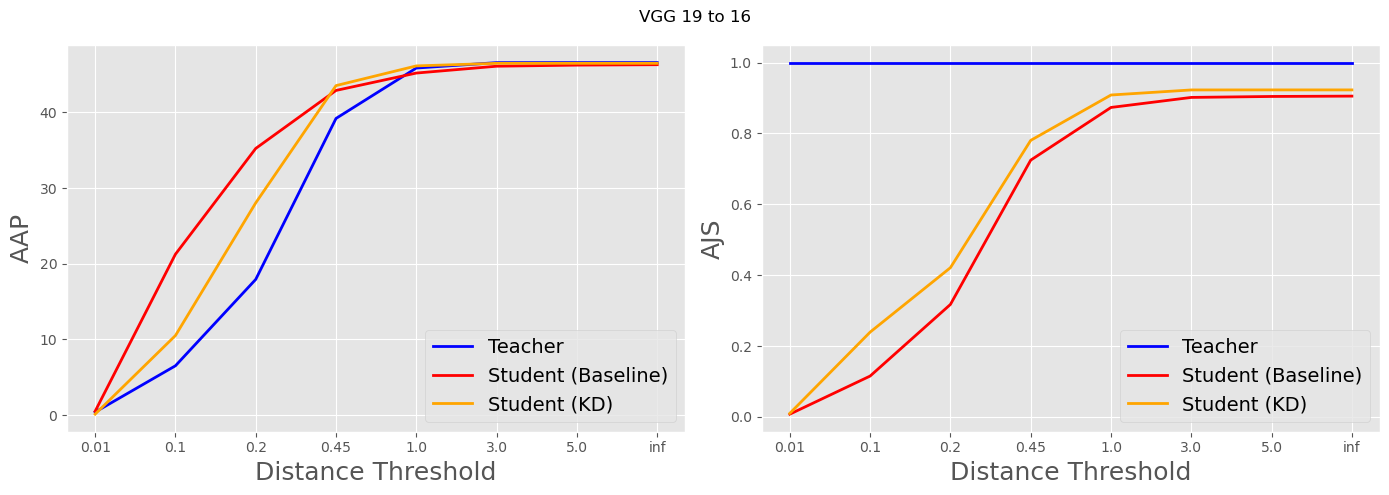

In [4]:
results_dir = 'results/vgg19_11'

AAP_teacher = []
AAP_kd = []
AAP_baseline = []
AJS_kd = []
AJS_baseline = []

distance_thresholds = [0.01, 0.1, 0.2, 0.45, 1.0, 3.0, 5.0, None]
for dt in distance_thresholds:
    with open(os.path.join(results_dir, str(dt), 'metrics.yaml'), "r") as file:
        metrics = yaml.load(file, Loader=yaml.FullLoader)
        AAP_teacher.append(metrics['aap']['teacher'])
        AAP_kd.append(metrics['aap']['kd_student'])
        AAP_baseline.append(metrics['aap']['baseline_student'])
        AJS_kd.append(metrics['ajs']['kd_student'])
        AJS_baseline.append(metrics['ajs']['baseline_student'])
distance_thresholds[-1] = 'inf'

f, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(distance_thresholds, AAP_teacher, label='Teacher', color='blue', linewidth=2)
axes[0].plot(distance_thresholds, AAP_baseline, label='Student (Baseline)', color='red', linewidth=2)
axes[0].plot(distance_thresholds, AAP_kd, label='Student (KD)', color='orange', linewidth=2)
axes[0].set_xlabel('Distance Threshold', fontsize=18)
axes[0].set_ylabel('AAP', fontsize=18)
axes[0].legend(loc='lower right', fontsize=14)
axes[1].plot(distance_thresholds, [1]*len(distance_thresholds), label='Teacher', color='blue', linewidth=2)
axes[1].plot(distance_thresholds, AJS_baseline, label='Student (Baseline)', color='red', linewidth=2)
axes[1].plot(distance_thresholds, AJS_kd, label='Student (KD)', color='orange', linewidth=2)
axes[1].set_xlabel('Distance Threshold', fontsize=18)
axes[1].set_ylabel('AJS', fontsize=18)
axes[1].legend(loc='lower right', fontsize=14)
plt.suptitle('VGG 19 to 16')
plt.tight_layout()
plt.show()


# Prototype Comparison

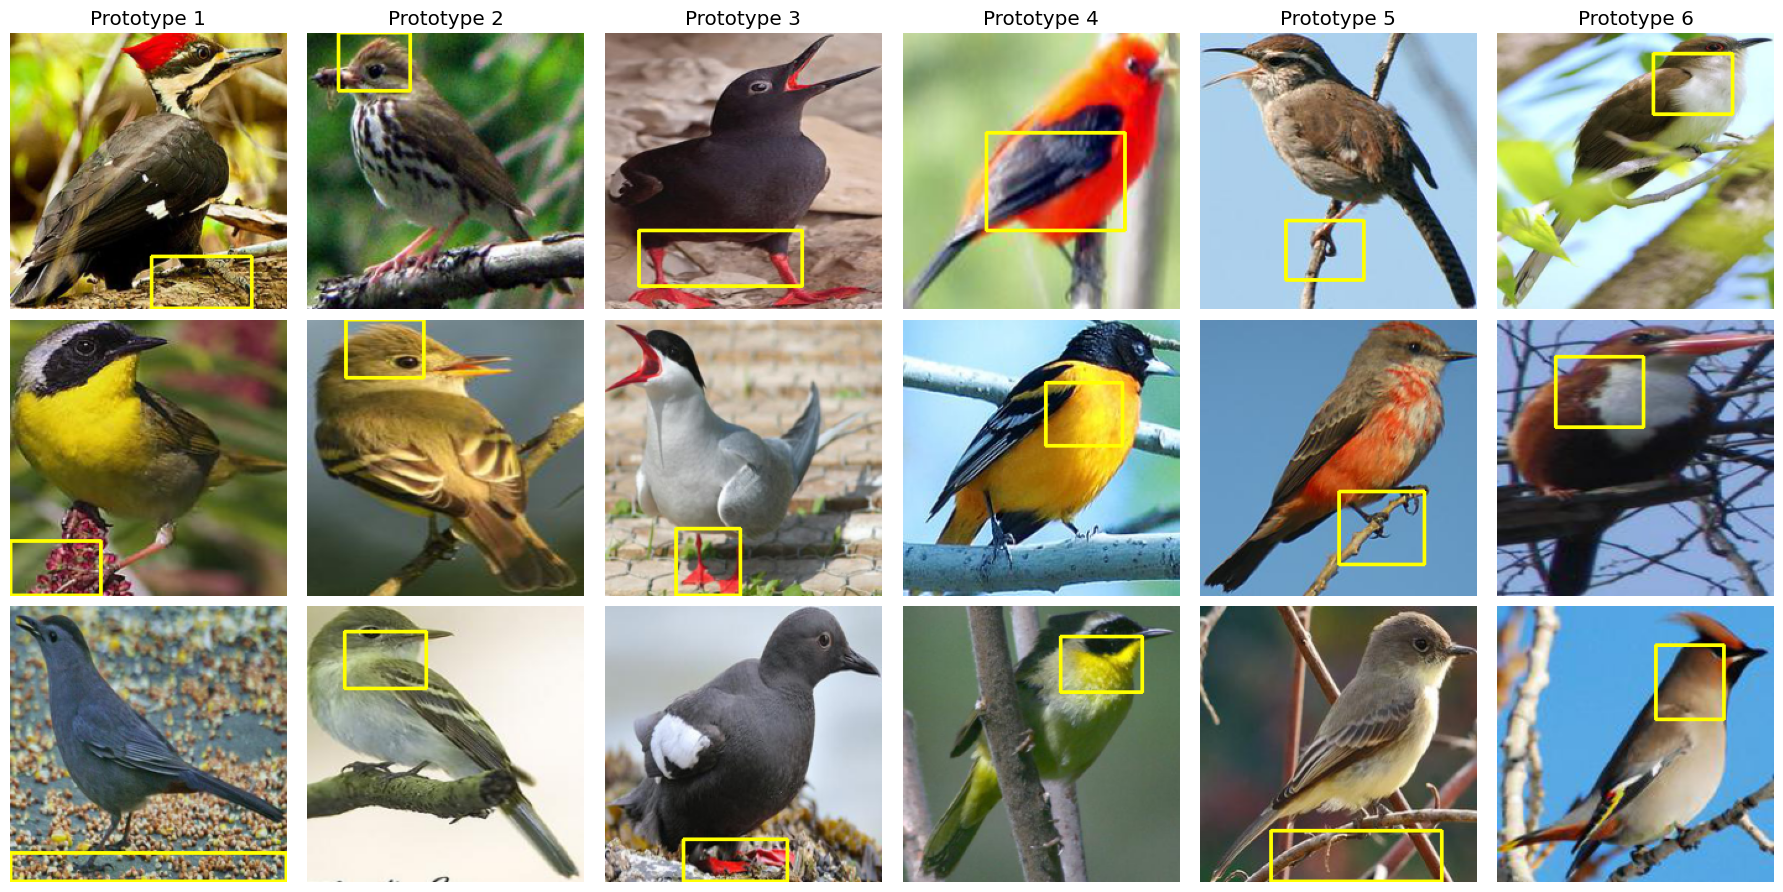

In [5]:
teacher_img_folder = 'nearest/vgg19_teacher/'
kd_student_img_folder = 'nearest/vgg11_kd/'
baseline_student_img_folder = 'nearest/vgg11_baseline/'

selection  = np.random.choice(range(2000), 6)
kd_allocation = np.load('results/vgg19_11/kd_best_allocation.npy')[1]
baseline_allocation = np.load('results/vgg19_11/baseline_best_allocation.npy')[1]

teacher_prototypes = selection
kd_student_prototypes = [kd_allocation[i] for i in selection]
baseline_student_prototypes = [baseline_allocation[i] for i in selection]

num_images = len(teacher_prototypes)

f, axes = plt.subplots(3, num_images, figsize=(num_images * 3, 9))
for i, p in enumerate(teacher_prototypes):
    img = Image.open(os.path.join(teacher_img_folder, f'{p:05d}', '01.png'))
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Prototype {i+1}')
    axes[0, i].set_ylabel('Teacher (VGG-19)', fontsize=13) if i == 0 else None
    axes[0, i].axis('off')
    # axes[0, i].get_xaxis().set_visible(False)
    # axes[0, i].get_yaxis().set_ticks([])
for i, p in enumerate(kd_student_prototypes):
    img = Image.open(os.path.join(kd_student_img_folder, f'{p:05d}', '01.png'))
    axes[1, i].imshow(img)
    axes[1, i].set_ylabel('KD Student (VGG-11)', fontsize=13) if i == 0 else None
    axes[1, i].axis('off')
    # axes[1, i].get_xaxis().set_visible(False)
    # axes[1, i].get_yaxis().set_ticks([])
for i, p in enumerate(baseline_student_prototypes):
    img = Image.open(os.path.join(baseline_student_img_folder, f'{p:05d}', '01.png'))
    axes[2, i].imshow(img)
    axes[2, i].set_ylabel('Baseline Student (VGG-11)', fontsize=13) if i == 0 else None
    axes[2, i].axis('off')
    # axes[2, i].get_xaxis().set_visible(False)
    # axes[2, i].get_yaxis().set_ticks([])
plt.tight_layout()
plt.show()